In [41]:
import numpy as np
import pandas as pd
from time import time

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Root path
root_path = "./data/"

In [46]:
def make_dataset(initial=False, period=2):
    """Cleaning and feature engineering on complete Olist data 
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    dpath : str
        Path to the directory containing the data.
    initial : boolean
        Defines whether the created dataset is the initial dataset.
    period : int
        Increment period in months after initial dataset.
    """
    

    # Load datasets
    customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
    geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
    orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
    order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
    order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
    products = pd.read_csv(root_path + "olist_products_dataset.csv")
    categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
    
    start_time = time()
    # - - - - - - - - - - Orders - - - - - - - - - - - - - - - 
    order_items = pd.merge(order_items, orders,
                       how="left",
                       on="order_id")

    del_features_list = ["seller_id", "shipping_limit_date",
                         "order_approved_at",
                         "order_delivered_carrier_date",
                         "order_estimated_delivery_date"]

    order_items.drop(del_features_list,
                     axis=1,
                     inplace=True)
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
    
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Select orders on period
    start = order_items["order_purchase_timestamp"].min()
    
    if(initial == True):
        period = 12
    else:
        period = 12+period
        
    stop = start + pd.DateOffset(months=period)
    
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english": "product_category_name"})
    
    products.drop(["product_category_name"], axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encode categories column
    #order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    numerical_value = order_items.select_dtypes(include=['int64','float64', 'uint8'])
    other_values = order_items.select_dtypes(exclude=['int64','float64', 'uint8'])
    imputer = KNNImputer(n_neighbors=5)
    data_knn = pd.DataFrame(imputer.fit_transform(numerical_value), columns = numerical_value.columns)
    order_items = pd.merge(data_knn, other_values, left_index=True, right_index=True)
    
    # Keep order items as input dataframe for predict 
    order_items.to_csv('./data/tests_set.tsv', index=False, sep = '\t')
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    # Final feature engineering
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    data.drop(["customer_state"], axis=1, inplace=True)

    end_time = time()
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    if features_to_fill:
        print(f"{features_to_fill}")
        
    return data

In [47]:
data_init = make_dataset(initial=True)

Durée d'execution du Feature engineering : 16.57s


In [7]:
data_init

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio
customer_unique_id,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3.0,178.0,0.20
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3.0,184.0,0.10
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7.0,48.0,0.52
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8.0,24.0,0.16
000de6019bb59f34c099a907c151d855,1,2,257.44,1.0,4.0,2.0,4.0,8.0,18.0,0.11
...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,1,1,102.74,1.0,2.0,5.0,17.0,8.0,24.0,0.17
fff699c184bcc967d62fa2c6171765f7,1,1,55.00,1.0,1.0,4.0,12.0,9.0,3.0,0.27
fffcf5a5ff07b0908bd4e2dbc735a684,1,2,2067.42,1.0,10.0,5.0,28.0,6.0,88.0,0.24


In [9]:
data_bis = make_dataset(initial=False, period=2)

Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 22.02s


In [10]:
data_bis # Create index custommer id -- Care re-index

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio
customer_unique_id,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3.0,239.0,0.20
0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,1.0,4.0,4.0,20.0,10.0,23.0,0.40
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3.0,245.0,0.10
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7.0,109.0,0.52
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8.0,85.0,0.16
...,...,...,...,...,...,...,...,...,...,...
fff699c184bcc967d62fa2c6171765f7,1,1,55.00,1.0,1.0,4.0,12.0,9.0,64.0,0.27
fffa431dd3fcdefea4b1777d114144f2,1,1,81.20,1.0,1.0,5.0,11.0,10.0,5.0,0.20
fffcf5a5ff07b0908bd4e2dbc735a684,1,2,2067.42,1.0,10.0,5.0,28.0,6.0,149.0,0.24


In [11]:
K = 4
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])

kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [12]:
from sklearn.metrics import adjusted_rand_score, v_measure_score, mutual_info_score

In [13]:
orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print(f"La période complète des commandes porte sur {time_delta} mois.")

La période complète des commandes porte sur 23 mois.


## Test with selection after the clustering

In [14]:
ari_score = []
v_score = []
mi_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = make_dataset(initial=False, 
                                   period=p)
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    
    kmeans_p.fit(data_period)
    
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Filter on initial customer client
    labels = [p_labels[i] for i,d in enumerate(data_period.index) if d in data_init.index]
    
    # Calculate Scoring
    ari_p = adjusted_rand_score(init_labels, labels)
    v_p = v_measure_score(init_labels, labels)
    mis = mutual_info_score(init_labels, labels)
    ari_score.append([p,ari_p])
    v_score.append([p,v_p])
    mi_score.append([p,mis])

Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 21.80s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 33.75s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 47.74s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 66.97s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 76.57s


In [15]:
from collections import defaultdict

ari = dict((x,y) for x, y in ari_score)
vscore = dict((x,y) for x, y in v_score)
miscore = dict((x,y) for x, y in mi_score)

scores = defaultdict(list)

for d in (ari, vscore, miscore): 
    for key, value in d.items():
        scores[key].append(value)
        
df = pd.DataFrame(scores).transpose()
df.columns=['ARI', 'V_SCORE', 'MI']
df.index.tolist(), df

([2, 4, 6, 8, 10],
          ARI   V_SCORE        MI
 2   0.296464  0.390178  0.484412
 4   0.209937  0.333113  0.390003
 6   0.199903  0.393156  0.436645
 8   0.198418  0.389283  0.436088
 10  0.197038  0.385457  0.434433)

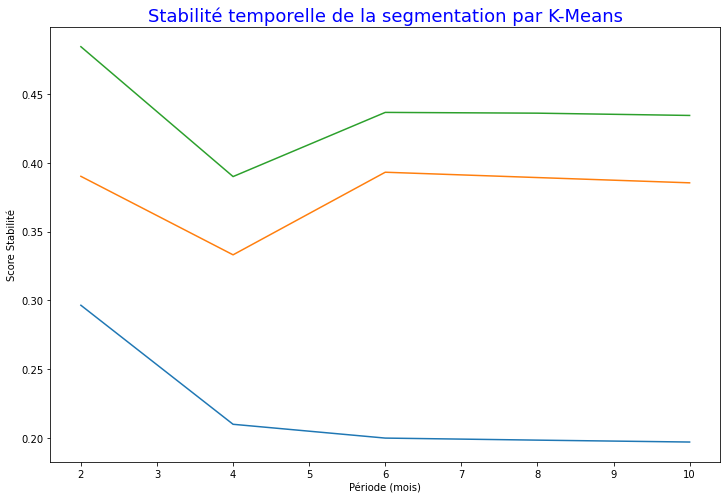

In [16]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df, x=df.index.tolist(), y="ARI")
sns.lineplot(data=df, x=df.index.tolist(), y="V_SCORE")
sns.lineplot(data=df, x=df.index.tolist(), y="MI")

plt.xlabel("Période (mois)")
plt.ylabel("Score Stabilité")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

## Test with selection before the clustering

In [17]:
ari_score = []
v_score = []
mi_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = make_dataset(initial=False, 
                                   period=p)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    v_p = v_measure_score(init_labels, kmeans_p[1].labels_)
    mis = mutual_info_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])
    v_score.append([p,v_p])
    mi_score.append([p,mis])
    ari_score.append([p,ari_p])

Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 22.33s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 33.67s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 47.30s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 63.34s
Datasets loaded
Création du dataset en cours ...
Durée d'execution du Feature engineering : 77.08s


In [18]:
from collections import defaultdict

ari = dict((x,y) for x, y in ari_score)
vscore = dict((x,y) for x, y in v_score)
miscore = dict((x,y) for x, y in mi_score)

scores = defaultdict(list)

for d in (ari, vscore, miscore): 
    for key, value in d.items():
        scores[key].append(value)
        
df = pd.DataFrame(scores).transpose()
df.columns=['ARI', 'V_SCORE', 'MI']
df.index.tolist(), df

([2, 4, 6, 8, 10],
          ARI   V_SCORE        MI
 2   0.962068  0.947301  1.233289
 4   0.701731  0.763212  1.001594
 6   0.697417  0.756006  0.992234
 8   0.677610  0.729564  0.958086
 10  0.677769  0.729544  0.958385)

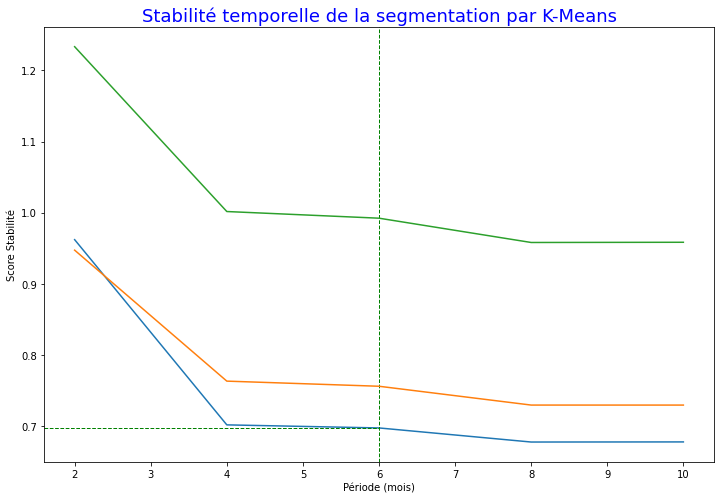

In [30]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df, x=df.index.tolist(), y="ARI")
plt.axhline(y=df['ARI'].iloc[2], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=df.iloc[2].name, linestyle="--", 
            color="green",
            linewidth=1)

sns.lineplot(data=df, x=df.index.tolist(), y="V_SCORE")
sns.lineplot(data=df, x=df.index.tolist(), y="MI")

plt.xlabel("Période (mois)")
plt.ylabel("Score Stabilité")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

In [38]:
## Fonction predict : à partir des informations de bases de client : Preprocessing / PCA 
## informations : dans tous les fichiers donc faire un merge 
# order_items : aggregation -> entrée de predict 
# 
kmeans_p.predict(data_init.iloc[:3])

array([1, 1, 1], dtype=int32)

In [50]:
df = pd.read_csv('./data/tests_set.tsv', sep = '\t')
df = df.sample(frac = 0.20)
df

,order_item_id,price,freight_value,sale_month,nb_payment_sequential,sum_payment_installments,review_score,delivery_delta_days,order_id,product_id,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_state
6575,1.0,136.99,21.27,2.0,1.0,1.0,1.0,17.0,3ed6a9a1b212121d7c0fde10bc8a65f2,dbf47a585df3a9d8f0b5f4c125a2b8e8,25fb0e680ef70980bcd26f8a2729c794,delivered,2017-02-13 02:45:53,8256d76e17831256264dd7ac35024705,SP
1784,1.0,299.99,36.72,2.0,1.0,10.0,5.0,21.0,10ccabd86a31f6939bd6b0eb1bbb1c67,cf78006a2a6b0429b9663edd99bb38f9,1183d7542b4266f421d6678da157fc09,delivered,2017-02-14 08:48:43,f006187fa998d6816c536308dfa3b33e,CE
13557,3.0,12.99,9.34,7.0,1.0,4.0,5.0,2.0,829d14a0e060598e3de477687e72a312,f7e5d0186f539b61586d7ddd247d2996,e9837d053b096d1d743efcaaae03cb95,delivered,2017-07-31 22:17:36,053b7090271ed4dacbfe0afd6382bbab,SP
14899,2.0,26.00,3.69,8.0,1.0,10.0,5.0,3.0,9015087bd3384196d2ed2265cba81150,cf1d8e226162a1d0ad61f29b7ed72d82,dbccb4da6723471cd6429812d0c3b086,delivered,2017-08-01 09:30:21,db29fa1f0d621557cec5d539a6e68050,MG
12607,1.0,199.90,19.68,2.0,1.0,1.0,4.0,6.0,792295382332f1170f1edc45dfade051,c7c27b5cbae5f0689560d8d154af7724,4fc752f9385483f2f1f6a309bff21be7,delivered,2017-02-08 13:05:17,bb0c181b34b3c55ac9019fdcf9933e4c,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20356,1.0,97.90,13.27,2.0,1.0,1.0,3.0,6.0,c3ec5c70256966fe8951602e15e63495,2b5bed5ddd304876b5d0c3eca2b6cbce,5679bf4d0900a0e28ce699536c8c3e43,delivered,2017-02-18 14:36:49,c400a61d8b936f7d10930fc142a39407,SP
18941,1.0,135.90,18.52,5.0,1.0,10.0,5.0,14.0,b669dbb8187ebd3a27a9d710d9e53194,78d7edf3fda961dc8ac6999761ba5b05,bcf47f22d180c8242c96c83bf11fdc51,delivered,2017-05-17 23:58:42,490365d9f683dc347884bd697db83052,RJ
24385,1.0,49.00,14.10,7.0,1.0,2.0,5.0,12.0,ea402a52e47bbc683974efe466ed5271,77fa3381855b6763c52ca3b72824f508,7c5abccd0319853b8b3718591f5e7117,delivered,2017-07-14 01:30:24,6589e66f8dd81a3779267e3b74e58a58,RJ
2342,1.0,59.90,9.74,7.0,1.0,2.0,5.0,2.0,165c8cb6857ddef74549e79056c60b06,4271f6581bae7660067afe25ac05de2e,549a9f5b9ac02e302a38f2e14c8929a3,delivered,2017-07-06 15:10:51,6fa4a159538a27ea01aebaf6b8181967,SP


In [87]:
def predict_input(order_items):
    print(order_items.dtypes)
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    order_items["order_purchase_timestamp"] = order_items["order_purchase_timestamp"].astype('datetime64[ns]')
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] else (y[0]).round('1d').day for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    data.drop(["customer_state"], axis=1, inplace=True)
    
    return kmeans_p.predict(data)

In [88]:
results = predict_input(df)

order_item_id                      float64
price                              float64
freight_value                      float64
sale_month                           int64
nb_payment_sequential              float64
sum_payment_installments           float64
review_score                       float64
delivery_delta_days                float64
order_id                            object
product_id                          object
customer_id                         object
order_status                        object
order_purchase_timestamp    datetime64[ns]
customer_unique_id                  object
customer_state                      object
dtype: object
nb_orders                             int64
total_items                           int64
total_spend                         float64
total_freight                       float64
mean_payment_sequential             float64
mean_payment_installments           float64
mean_review_score                   float64
mean_delivery_days               

In [91]:
results

array([3, 1, 0, ..., 0, 0, 0], dtype=int32)